# Talos Captcha Kraken
Autoencoder+Recurrent Neural Network for Variable Length Captcha Recognition


Yvonne Yang
1006084381

In [ ]:
use_cuda = True # use GPU
torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [2]:
model_folder_path="/content/drive/MyDrive/AERNN_models/"
noisy_data_folder_path="/content/drive/MyDrive/Captcha_Datasets/generated_by_us/captchas_4to8_chars/data320x144"
pair_data_folder_path="/content/drive/MyDrive/Captcha_Datasets/generated_by_us/captcha_denoised_pairs"

In [3]:
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
import os
import numpy as np
from tqdm.notebook import tqdm
import gc
from torch.utils.data.dataset import Dataset
from PIL import Image

## Data processing

In [ ]:
def process_data(folder):
  os.makedirs(folder+"/"+"noisy", exist_ok=True)
  os.makedirs(folder+"/"+"denoised", exist_ok=True)
  for i, name in tqdm(enumerate(os.listdir(folder))):
    if name.endswith(".jpg") or name.endswith(".png"):
      img = Image.open(folder+"/"+name)
      width, height = img.size
      noisy = img.crop((0, 0, width//2, height))
      label = name.lower().replace(" ","") # lowercase and remove space
      noisy.save(folder+"/noisy/"+label)
      denoised = img.crop((width//2, 0, width, height))
      denoised.save(folder+"/denoised/"+label)
      if i == 0:
        print(label)
        plt.imshow(img)
        plt.figure()
        plt.imshow(noisy)
        plt.figure()
        plt.imshow(denoised)

0it [00:00, ?it/s]

7kcbsctzu.png


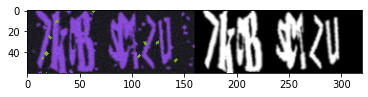

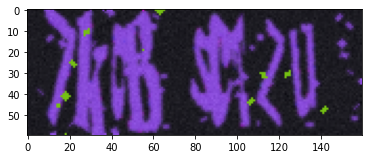

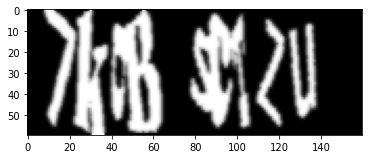

In [ ]:
# Shouldn't need to do this again!
# process_data(pair_data_folder_path+"/train")

0it [00:00, ?it/s]

pmmv8kuvc.png


0it [00:00, ?it/s]

4xkse.png


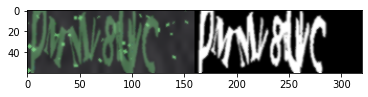

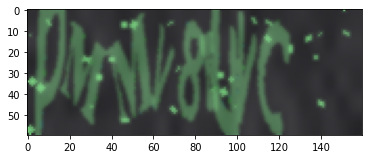

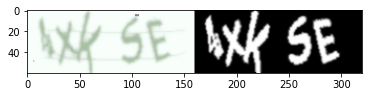

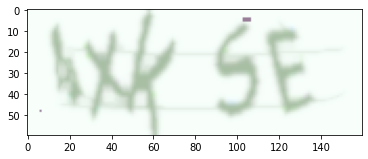

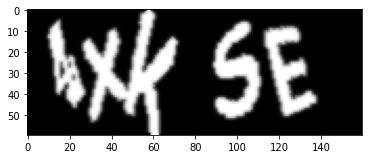

In [ ]:
# process_data(pair_data_folder_path+"/val")
# process_data(pair_data_folder_path+"/test")

Train samples: 2000
Val samples: 750
Test samples: 750


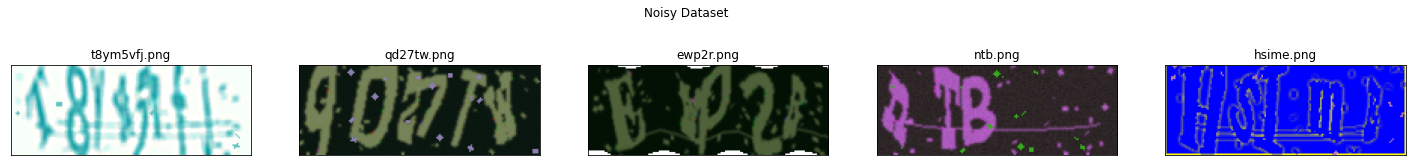

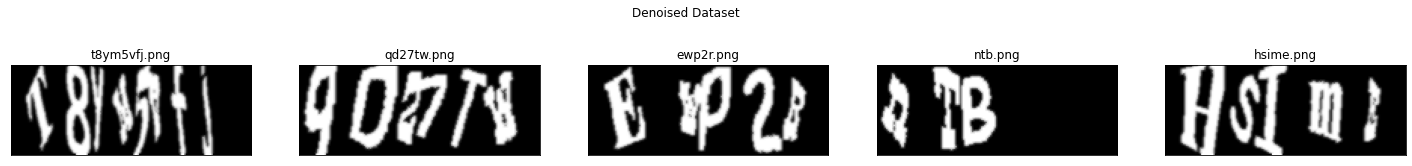

In [4]:
# Count number of samples
print ("Train samples:", len([f for f in os.listdir(pair_data_folder_path+"/train") if os.path.isfile(os.path.join(pair_data_folder_path+"/train", f))]))
print ("Val samples:", len([f for f in os.listdir(pair_data_folder_path+"/val") if os.path.isfile(os.path.join(pair_data_folder_path+"/val", f))]))
print ("Test samples:", len([f for f in os.listdir(pair_data_folder_path+"/test") if os.path.isfile(os.path.join(pair_data_folder_path+"/test", f))]))

class VariableLengthCaptchaDataset(Dataset):
    def __init__(self, folder, transforms=transforms.ToTensor()):
      self.folder=folder
      self.transforms = transforms
      self.samples = [name for name in os.listdir(folder) \
                      if not name.startswith(".") and (name.endswith(".jpg") or name.endswith(".png"))]
        
    def __getitem__(self, index):
        data = Image.open(self.folder+"/"+self.samples[index])
        if self.transforms is not None:
            data = self.transforms(data)     
        label = self.samples[index]
        return (data, label)

    def __len__(self):
        return len(self.samples) 
        
noisy_train_data = VariableLengthCaptchaDataset(pair_data_folder_path+"/train/noisy")
noisy_val_data = VariableLengthCaptchaDataset(pair_data_folder_path+"/val/noisy")
noisy_test_data = VariableLengthCaptchaDataset(pair_data_folder_path+"/test/noisy")
denoised_train_data = VariableLengthCaptchaDataset(pair_data_folder_path+"/train/denoised")
denoised_val_data = VariableLengthCaptchaDataset(pair_data_folder_path+"/val/denoised")
denoised_test_data = VariableLengthCaptchaDataset(pair_data_folder_path+"/test/denoised")

# Visualize the dataset
def visualize_data(images, labels, title=None,  n_per_label=3):
  fig = plt.figure(figsize=(25, 3))
  fig.suptitle(title)
  for idx in np.arange(n_per_label*5):
      ax = fig.add_subplot(n_per_label, 5, idx+1, xticks=[], yticks=[])
      plt.imshow(np.transpose(images[idx],(1, 2, 0)))
      ax.set_title(labels[idx])

batch=5
noisy_train_loader = torch.utils.data.DataLoader(noisy_train_data,  batch_size=batch)
images, labels = iter(noisy_train_loader).next()
visualize_data(images, labels, title="Noisy Dataset",n_per_label=1)

batch=5
denoised_train_loader = torch.utils.data.DataLoader(denoised_train_data,batch_size=batch)
images, labels = iter(denoised_train_loader).next()
visualize_data(images, labels, title="Denoised Dataset",  n_per_label=1)

In [5]:
class Autoencoder(nn.Module):
    def __init__(self, conv_channels=None, kernel_sizes=[3,3,5]):
      if conv_channels is None:
        conv_channels = [3, 9, 27, 81]
      self.conv_channels = conv_channels.copy()
      self.kernel_sizes = kernel_sizes.copy()
      super(Autoencoder, self).__init__()
      self.encoder = nn.Sequential(
        nn.Conv2d(conv_channels[0], conv_channels[1], kernel_sizes[0]),
        nn.ReLU(),
        nn.Conv2d(conv_channels[1], conv_channels[2], kernel_sizes[1]),
        nn.ReLU(),
        nn.Conv2d(conv_channels[2], conv_channels[3], kernel_sizes[2])
      )
      self.decoder = nn.Sequential(
          nn.ConvTranspose2d(conv_channels[3], conv_channels[2], kernel_sizes[2]),
          nn.ReLU(),
          nn.ConvTranspose2d(conv_channels[2], conv_channels[1], kernel_sizes[1]),
          nn.ReLU(),
          nn.ConvTranspose2d(conv_channels[1], conv_channels[0], kernel_sizes[0])
      )


    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Train AE, then Encoder+RNN

In [6]:
num_workers=2

def build_and_train_AE(model_path=None,
                        noisy=True, num_epochs=5, batch_size=64, learning_rate=1e-3,
                        from_epoch=0, save_every=5):
    torch.manual_seed(360)
    
    if model_path is None:
      model_path="noisy" + f"_lr={learning_rate}_bs={batch_size}" if noisy \
            else "denoi" + f"_lr={learning_rate}_bs={batch_size}"
    if noisy:
      train_loader = torch.utils.data.DataLoader(noisy_train_data, 
                                               batch_size=batch_size, 
                                               num_workers=num_workers,
                                               shuffle=True)
      val_loader = torch.utils.data.DataLoader(noisy_val_data, 
                                               batch_size=batch_size, 
                                               num_workers=num_workers,
                                               shuffle=True)
    else:
      train_loader = torch.utils.data.DataLoader(denoised_train_data, 
                                               batch_size=batch_size, 
                                               num_workers=num_workers,
                                               shuffle=True)
      val_loader = torch.utils.data.DataLoader(denoised_val_data, 
                                               batch_size=batch_size, 
                                               num_workers=num_workers,
                                               shuffle=True)
    model = Autoencoder()
    train_AE(model, train_loader, val_loader,
             model_path=model_path,
             noisy=noisy, num_epochs=num_epochs, batch_size=batch_size, learning_rate=learning_rate,
             from_epoch=from_epoch,save_every=save_every)
    

def train_AE(model, train_loader, val_loader,
             model_path=None,
             noisy=True, num_epochs=5, batch_size=64, learning_rate=1e-3,
             from_epoch=0, save_every=5):
    torch.manual_seed(42)
    criterion = nn.MSELoss() # mean square error loss
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, 
                                 weight_decay=1e-5)
    outputs, losses = [], []

    os.makedirs(model_folder_path+model_path, exist_ok=True)
    
    for epoch in tqdm(range(from_epoch, num_epochs+from_epoch)):
        for data in tqdm(train_loader, leave=True):
            img, _ = data
            recon = model(img)
            loss = criterion(recon, img)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            losses.append(loss.detach().numpy())

        if epoch % save_every == 0 or epoch == from_epoch+num_epochs-1:
            torch.save(model.state_dict(), model_folder_path+model_path+"/_"+str(epoch)+".pt")

        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        outputs.append((epoch, img, recon),)
    
    np.savetxt(model_folder_path+model_path+f"/loss_{from_epoch}_to_{from_epoch+num_epochs}.csv", 
           losses,
           delimiter =", ", 
           fmt ='% s')
    # plotting
    plt.title("Training Curve")
    iters = range(len(losses))
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.savefig(model_folder_path+model_path+f"/loss_e{epoch}.jpg")
    plt.show()
    return outputs

In [ ]:
build_and_train_AE(noisy=False, batch_size=256, num_epochs=5, save_every=1)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:1, Loss:0.0278


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:2, Loss:0.0206


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:2, Loss:0.0635


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:3, Loss:0.0464


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:4, Loss:0.0315


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:5, Loss:0.0281


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:6, Loss:0.0262


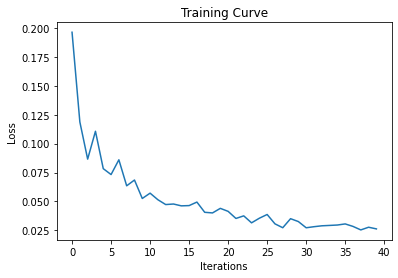

In [10]:
build_and_train_AE(batch_size=256, num_epochs=5, from_epoch=1, save_every=1)

### Train CNN+RNN

#### Scrap code

In [ ]:
def get_accuracy(model, data_loader, debug=False, features=None):
    correct = 0
    total = 0
    for i, (imgs, labels) in enumerate(data_loader):
        
         
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
        
        if features is None:
          output = model(imgs)
        else:
          output = model(features[i])

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]

        if debug:
          print("pred: ", pred)
          print("true labels: ", labels.view_as(pred))
    return correct / total

In [ ]:
def build_and_train(overfit_set=None, # whether to use the "overfit" dataset
                    hiddens=None, learning_rate=0.001, batch_size=64, num_epochs=1, # hyperparameters
                    save_every=5, model_path=None, # logs
                    from_epoch=0 # continue training from checkpoint
                    ):
    if model_path is None:
      hidden_units = "_".join([str(hd) for hd in hiddens])
      model_path=f"hd={hidden_units}_lr={learning_rate}_bs={batch_size}"

    # prepare data loaders and model
    num_workers = 1
    if overfit_set is None:
      train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                                num_workers=num_workers, shuffle=False, pin_memory=True)
      val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, 
                                                num_workers=num_workers, shuffle=False, pin_memory=True)
    else:
      model_path="small_"+model_path
      train_loader = overfit_set
      val_loader = None
    
    model = CNN(hiddens)
    ############## GPU usage
    if use_cuda and torch.cuda.is_available():
      model.cuda()
    ########################

    if from_epoch != 0:
      model.load_state_dict(torch.load(model_folder_path+model_path+"/_epoch"+str(from_epoch)+".pt"))
      print("loaded model acc:", get_accuracy(model, train_loader))

    print(model)
    train(model, train_loader, val_loader, model_path=model_path, learning_rate=learning_rate, batch_size=batch_size, num_epochs=num_epochs, from_epoch=from_epoch, save_every=save_every)
    
    if use_cuda and torch.cuda.is_available():
      del model
      gc.collect()
      torch.cuda.empty_cache()


def train(model, train_loader, val_loader, model_path=None, learning_rate=0.001, batch_size=64, num_epochs=1, from_epoch=0, save_every=5):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    os.makedirs(model_folder_path+model_path, exist_ok=True)
    for epoch in tqdm(range(from_epoch, from_epoch+num_epochs)):
        for imgs, labels in (tqdm(iter(train_loader), leave=False) if val_loader is not None else iter(train_loader)):
              
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################

            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            losses.append(float(loss)/batch_size)             # compute *average* loss

        t_acc = get_accuracy(model, train_loader) # compute training accuracy 
        train_acc.append(t_acc)
        if val_loader is not None: # not the overfit experiment
          v_acc = get_accuracy(model, val_loader)
          val_acc.append(v_acc)  # compute validation accuracy
        if epoch % save_every == 0 or epoch == from_epoch+num_epochs-1:
          torch.save(model.state_dict(), model_folder_path+model_path+"/_epoch"+str(epoch)+".pt")
          print("Checkpoint ", end=None)
        print("epoch ", epoch, " loss=", losses[-1], " train_acc=", t_acc, " val_acc=", v_acc if val_loader is not None else "(NA)")

    # plotting
    plt.title("Training Curve")
    iters = range(len(losses))
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.savefig(model_folder_path+model_path+f"/loss_e{epoch}.jpg")
    plt.show()

    iters = range(from_epoch, from_epoch+num_epochs)
    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    if val_loader is not None:
      plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    final_acc = val_acc[-1] if val_loader is not None else train_acc[-1]
    plt.savefig(model_folder_path+model_path+f"/acc_e{epoch}_{final_acc:.2f}.jpg")
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    if val_loader is not None:
      print("Final Validation Accuracy: {}".format(val_acc[-1]))